In [2]:
import cftime
import glob
import matplotlib.pyplot as plt
import mpl_scatter_density
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy import stats
from scipy import io

import mission_tools

# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

Text(0, 0.5, 'Dissipation')

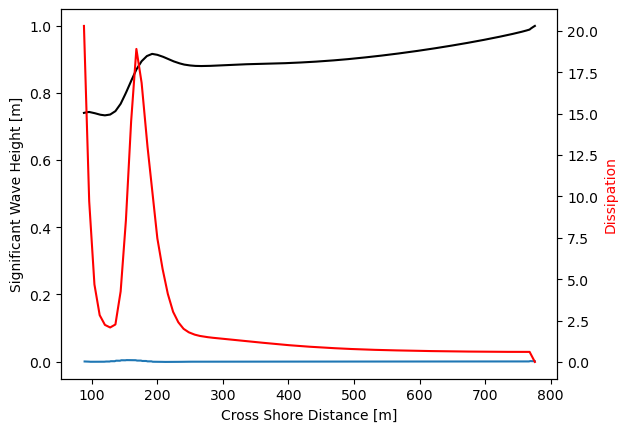

In [10]:
# Load SWAN Output Data
Hs_swan = io.loadmat('../data/model_data/swan_small/Hs.mat')['Hsig']
dissip_swan = io.loadmat('../data/model_data/swan_small/dissip.mat')['Dissip']
xmin = 0
xmax = 777 # Need to add one more point since it is not included
delx = 1
x = np.arange(xmin, xmax, step=delx)

# Alongshore average the Hs and dissipation values
Hs_swan_profile = np.mean(Hs_swan, axis=0)
dissip_swan_profile = np.mean(dissip_swan, axis=0)

fig, ax1 = plt.subplots()
ax1.plot(x, Hs_swan_profile, color='k')
# ax1.plot(x, np.gradient(Hs_swan_profile))
ax1.set_ylabel('Significant Wave Height [m]')
ax1.set_xlabel('Cross Shore Distance [m]')
ax2 = ax1.twinx()
ax2.plot(dissip_swan_profile, color='r')
ax2.set_ylabel('Dissipation', color='r')





In [9]:
mission_list = ['../data/microswift_missions/mission_25.nc']
wave_heights_all = []
wave_x_locs_all = []
wave_y_locs_all = []
wave_times_all = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')
    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]
    time_units = mission_dataset['time'].units
    time_calendar = mission_dataset['time'].calendar
    median_mission_time = np.median(time)

    wave_heights, \
    wave_x_locs, \
    wave_y_locs, \
    wave_times = mission_tools.compute_individual_waves(x_locations, y_locations,
                                                        eta, time, time_units,
                                                        time_calendar,
                                                        single_trajectory=False )
    
    wave_heights_all.append(wave_heights)
    wave_x_locs_all.append(wave_x_locs)
    wave_y_locs_all.append(wave_y_locs)
    wave_times_all.append(wave_times)

# Flatten the lists of lists
wave_heights_all = list(np.concatenate(wave_heights_all).flat)
wave_x_locs_all = list(np.concatenate(wave_x_locs_all).flat)
wave_y_locs_all = list(np.concatenate(wave_y_locs_all).flat)
wave_times_all = list(np.concatenate(wave_times_all).flat)

In [60]:
# Compute Bathymetry under each wave from average location
bathy_file = '../data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs_all,
                                              wave_y_locs_all,
                                              bathy_file)

# Adjust bathymetry for the water depths based on water level gauge
water_level_dataset = nc.Dataset('../data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc')
water_level_time = water_level_dataset['time'][:]
water_level = water_level_dataset['waterLevel'][:]

num_waves = len(wave_times_all)
wave_depths = []
for n in range(num_waves):
    mean_water_level = np.interp(wave_times_all[n],
                                 water_level_time,
                                 water_level)
    wave_depths.append(np.abs(wave_bathy[n] - mean_water_level))

In [61]:
# Create a pandas dataframe from all wave data
wave_df = pd.DataFrame(cftime.num2pydate(wave_times_all, units=time_units,
                       calendar=time_calendar), columns=['time'])
wave_df['height [m]'] = wave_heights_all
wave_df['cross shore location [m]'] = wave_x_locs_all
wave_df['along shore location [m]'] = wave_y_locs_all
wave_df['depth [m]'] = wave_depths

# Remove any rows that have nan values for depth - occurs when they drift
# out of the measured area
wave_df = wave_df.dropna()

wave_df

,time,height [m],cross shore location [m],along shore location [m],depth [m]
0,2021-10-11 14:11:10.333292,0.856765,517.217905,358.342833,6.882188
1,2021-10-11 14:11:16.083269,1.389866,515.818714,355.014443,6.852105
2,2021-10-11 14:11:22.291578,0.736738,514.389271,351.681914,6.823049
3,2021-10-11 14:11:28.749885,2.011763,512.746930,348.468459,6.791805
4,2021-10-11 14:11:37.374851,1.066366,513.028781,343.905293,6.781769
...,...,...,...,...,...
4607,2021-10-11 14:22:38.622205,1.124258,268.703595,-183.257921,4.300499
4608,2021-10-11 14:22:45.330512,1.262441,267.192569,-188.241258,4.273755
4609,2021-10-11 14:22:51.913819,2.005185,262.974888,-193.333477,4.180758
4610,2021-10-11 14:23:02.247111,3.925941,270.810196,-202.167565,4.344106


In [62]:
def scatter_density(x, y, fig, ax):
    """
    Plot a scatter plot with color showing the probability density function
    as the color.

    Parameters
    ----------
    x : np.ndarray or list

    y : np.ndarray or list
        
    """
    xy = np.vstack([x,y])
    density = stats.gaussian_kde(xy)(xy)
    im = ax.scatter(x, y, c=density)
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Probability Density')


(0.0, 2.7)

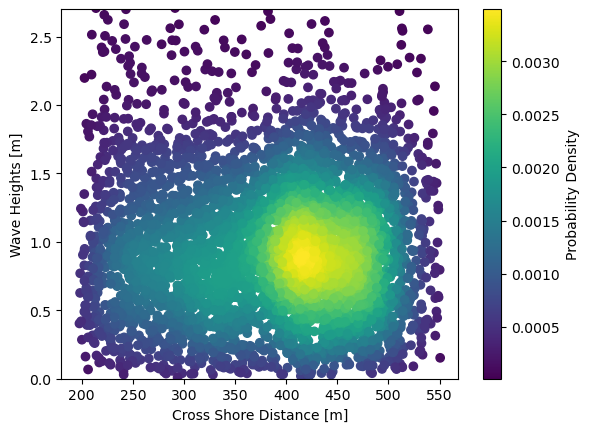

In [63]:
fig, ax = plt.subplots()
scatter_density(wave_df['cross shore location [m]'], wave_df['height [m]'],
                fig, ax)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Wave Heights [m]')
ax.set_ylim(0, 2.7)

Text(0, 0.5, 'Gamma [H/d]')

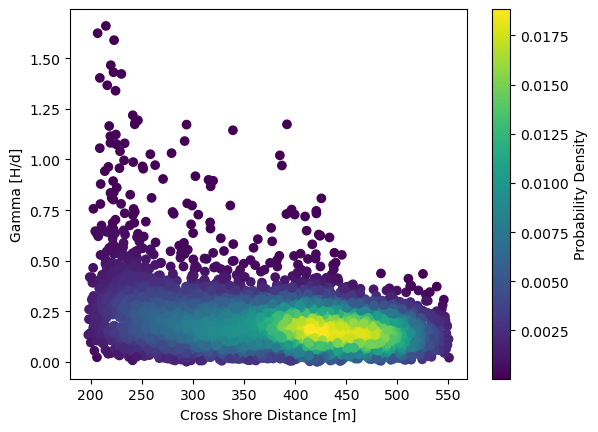

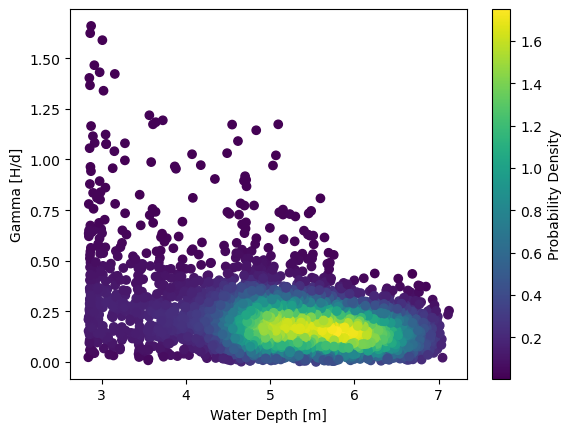

In [64]:
# Compute Gamma for each individual wave
wave_df['gamma'] = wave_df['height [m]'] / wave_df['depth [m]']

# Plot Gamma as function of cross shore distance
fig, ax = plt.subplots()
scatter_density(wave_df['cross shore location [m]'], wave_df['gamma'],
                fig, ax)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Gamma [H/d]')

# # Plot Gamma as a function of Water Depth
fig, ax = plt.subplots()
scatter_density(wave_df['depth [m]'], wave_df['gamma'],
                fig, ax)
ax.set_xlabel('Water Depth [m]')
ax.set_ylabel('Gamma [H/d]')

In [65]:
# Compute Phase Speed of each wave
g = 9.8 # gravitational acceleration 
wave_df['phase speed [m/s]'] = np.sqrt(g * wave_df['depth [m]'])

wave_df



,time,height [m],cross shore location [m],along shore location [m],depth [m],gamma,phase speed [m/s]
0,2021-10-11 14:11:10.333292,0.856765,517.217905,358.342833,6.882188,0.124490,8.212517
1,2021-10-11 14:11:16.083269,1.389866,515.818714,355.014443,6.852105,0.202838,8.194549
2,2021-10-11 14:11:22.291578,0.736738,514.389271,351.681914,6.823049,0.107978,8.177156
3,2021-10-11 14:11:28.749885,2.011763,512.746930,348.468459,6.791805,0.296204,8.158412
4,2021-10-11 14:11:37.374851,1.066366,513.028781,343.905293,6.781769,0.157240,8.152382
...,...,...,...,...,...,...,...
4607,2021-10-11 14:22:38.622205,1.124258,268.703595,-183.257921,4.300499,0.261425,6.491910
4608,2021-10-11 14:22:45.330512,1.262441,267.192569,-188.241258,4.273755,0.295394,6.471692
4609,2021-10-11 14:22:51.913819,2.005185,262.974888,-193.333477,4.180758,0.479622,6.400893
4610,2021-10-11 14:23:02.247111,3.925941,270.810196,-202.167565,4.344106,0.903740,6.524741


Offshore significant wave height is 1.63


Text(0, 0.5, 'Number of Wave Realizations in Bin [-]')

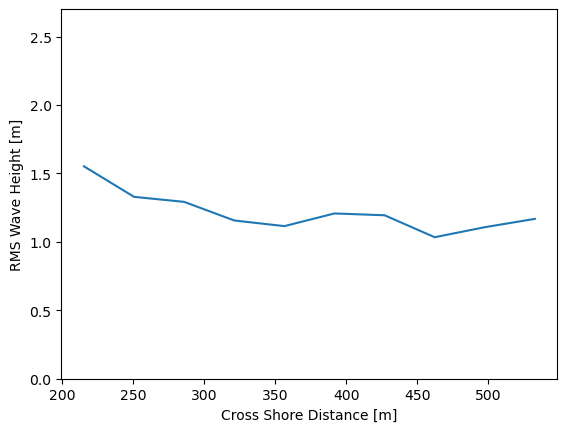

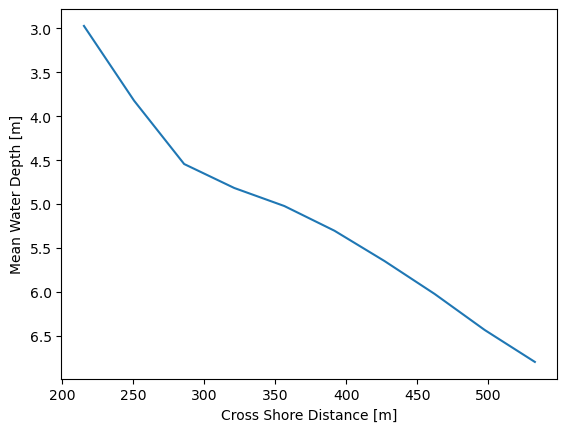

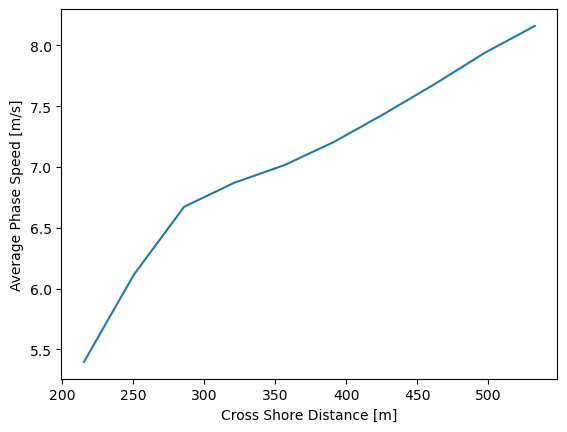

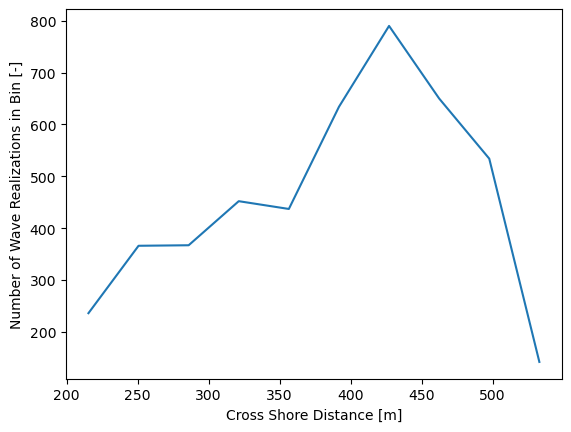

In [87]:
# Organize the waves into Cross shore Distance Bins
cross_shore_bin_size = 30
cross_shore_min = np.min(wave_df['cross shore location [m]'])
cross_shore_max = np.max(wave_df['cross shore location [m]'])
cross_shore_num_bins = int(np.floor((cross_shore_max - cross_shore_min)/ \
                                 cross_shore_bin_size))

cross_shore_bin_edges = np.linspace(cross_shore_min, cross_shore_max,
                                    cross_shore_num_bins)

cross_shore_bin_centers = (cross_shore_bin_edges[1:] + \
                           cross_shore_bin_edges[:-1]) / 2

h_rms_profile = []
mean_depth_profile = []
phase_speed_profile = []
num_waves_in_bin = []
for n in range(cross_shore_bin_centers.size):
    df = wave_df[wave_df['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                             cross_shore_bin_edges[n+1])]
    h_rms_profile.append(np.sqrt(np.mean(np.power(df['height [m]'], 2))))
    mean_depth_profile.append(np.mean(df['depth [m]']))
    phase_speed_profile.append(np.mean(df['phase speed [m/s]']))
    num_waves_in_bin.append(len(df.index))

Hs_offshore = np.round(h_rms_profile[-1] * 1.4, 2)
print(f'Offshore significant wave height is {Hs_offshore}')

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, h_rms_profile, label='microSWIFT Array')
# ax.plot(x, Hs_swan_profile/1.4, label='SWAN profile')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('RMS Wave Height [m]')
# ax.legend()
ax.set_ylim(0, 2.7)

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, mean_depth_profile)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Mean Water Depth [m]')
ax.invert_yaxis()

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, phase_speed_profile)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Average Phase Speed [m/s]')

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, num_waves_in_bin)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Number of Wave Realizations in Bin [-]')


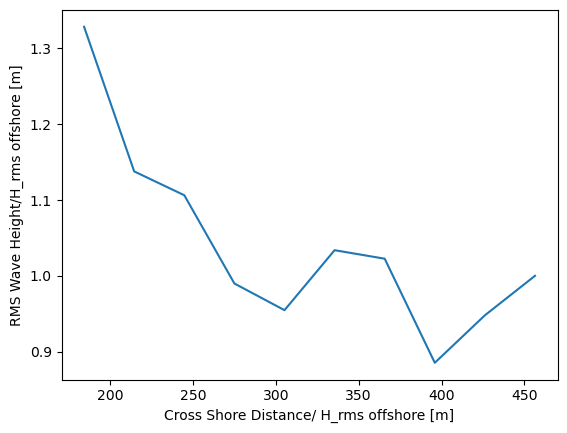

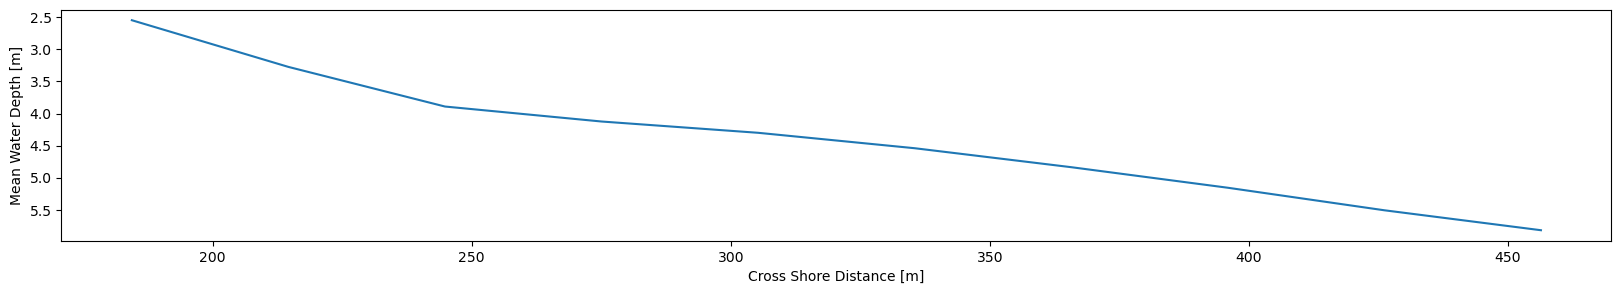

In [88]:
# Normalized RMS wave height profile
fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers/h_rms_profile[-1], h_rms_profile/h_rms_profile[-1])
ax.set_xlabel('Cross Shore Distance/ H_rms offshore [m]')
ax.set_ylabel('RMS Wave Height/H_rms offshore [m]')
# ax.set_ylim(0, 1.7)

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(cross_shore_bin_centers/h_rms_profile[-1], mean_depth_profile/h_rms_profile[-1])
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Mean Water Depth [m]')
ax.invert_yaxis()

Text(0, 0.5, 'Energy/area [J/m^2]')

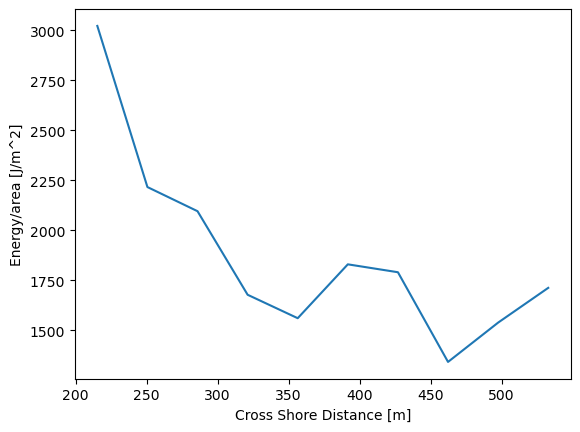

In [89]:
# Compute Energy as a function of cross shore distance
rho = 1025 # density of seawater approximately, kg/m^3
energy_profile = (1/8) * rho * g * np.power(h_rms_profile, 2)

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, energy_profile)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Energy/area [J/m^2]')

Text(0, 0.5, 'Energy Flux [W/m]')

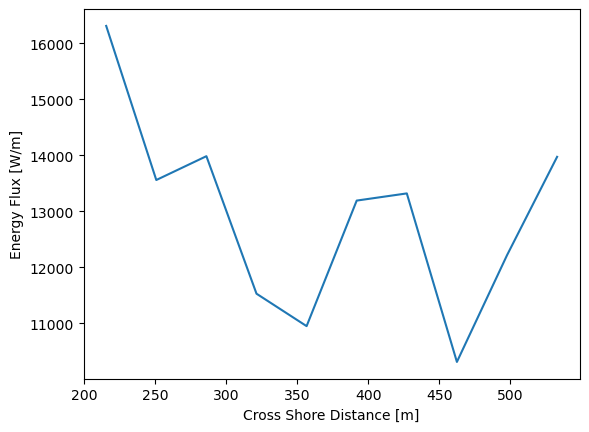

In [90]:
# Compute Energy flux as a function of cross shore distance
energy_flux_profile = energy_profile * phase_speed_profile

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, energy_flux_profile)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Energy Flux [W/m]')

Text(0, 0.5, 'Energy Dissipation Rate [W/m^2]')

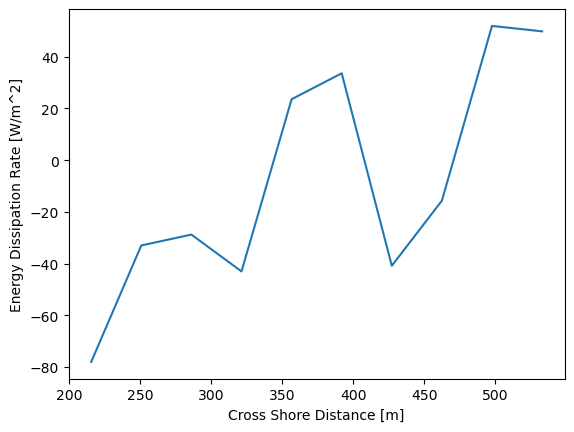

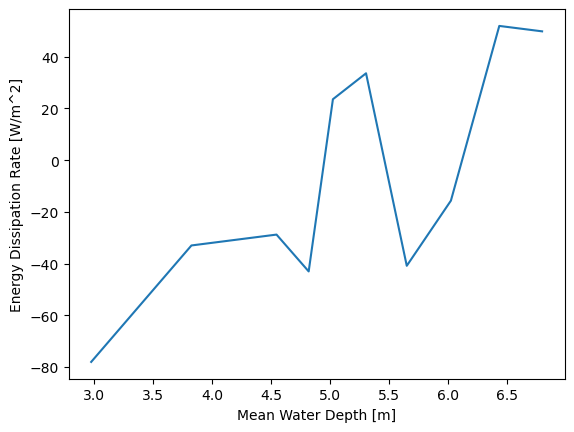

In [91]:
# Compute Energy Dissipation as a function of cross shore distance
energy_dissipation_profile = np.gradient(energy_flux_profile, cross_shore_bin_centers)

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, energy_dissipation_profile, label='microSWIFT Array')
# ax.plot(x, dissip_swan_profile, label='SWAN profile')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Energy Dissipation Rate [W/m^2]')
# ax.legend()

fig, ax = plt.subplots()
ax.plot(mean_depth_profile, energy_dissipation_profile, label='microSWIFT Array')
# ax.plot(x, dissip_swan_profile, label='SWAN profile')
ax.set_xlabel('Mean Water Depth [m]')
ax.set_ylabel('Energy Dissipation Rate [W/m^2]')

In [92]:
# Compute Phase Speed Profile using Solitary Wave Theory
wave_df['phase speed (swt) [m/s]'] = np.sqrt(g * wave_df['depth [m]'] * \
                                    (1 + (wave_df['height [m]'] / wave_df['depth [m]'])))
wave_df

,time,height [m],cross shore location [m],along shore location [m],depth [m],gamma,phase speed [m/s],phase speed (swt) [m/s]
0,2021-10-11 14:11:10.333292,0.856765,517.217905,358.342833,6.882188,0.124490,8.212517,8.708716
1,2021-10-11 14:11:16.083269,1.389866,515.818714,355.014443,6.852105,0.202838,8.194549,8.987287
2,2021-10-11 14:11:22.291578,0.736738,514.389271,351.681914,6.823049,0.107978,8.177156,8.607317
3,2021-10-11 14:11:28.749885,2.011763,512.746930,348.468459,6.791805,0.296204,8.158412,9.288431
4,2021-10-11 14:11:37.374851,1.066366,513.028781,343.905293,6.781769,0.157240,8.152382,8.769933
...,...,...,...,...,...,...,...,...
4607,2021-10-11 14:22:38.622205,1.124258,268.703595,-183.257921,4.300499,0.261425,6.491910,7.291270
4608,2021-10-11 14:22:45.330512,1.262441,267.192569,-188.241258,4.273755,0.295394,6.471692,7.365780
4609,2021-10-11 14:22:51.913819,2.005185,262.974888,-193.333477,4.180758,0.479622,6.400893,7.786029
4610,2021-10-11 14:23:02.247111,3.925941,270.810196,-202.167565,4.344106,0.903740,6.524741,9.002581


Text(0, 0.5, 'Average Phase Speed (swt) [m/s]')

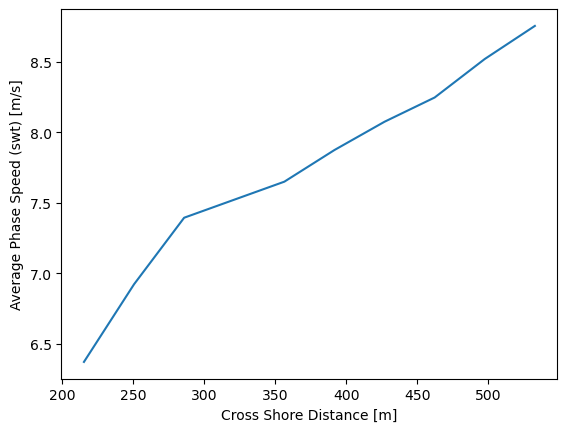

In [93]:
# Solitary Wave Theory Phase Speed Profile
swt_phase_speed_profile = []
for n in range(cross_shore_bin_centers.size):
    df = wave_df[wave_df['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                             cross_shore_bin_edges[n+1])]
    swt_phase_speed_profile.append(np.mean(df['phase speed (swt) [m/s]']))

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, swt_phase_speed_profile)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Average Phase Speed (swt) [m/s]')


Text(0, 0.5, 'Energy Flux [W/m]')

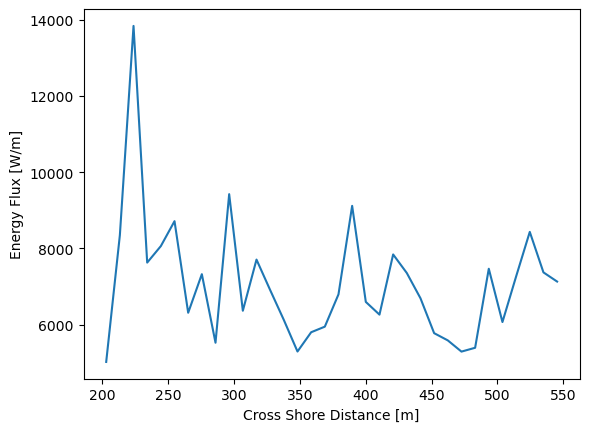

In [73]:
# Energy Flux Solitary Wave theory
energy_flux_profile_swt = energy_profile * 0.5 * swt_phase_speed_profile

fig, ax = plt.subplots()
ax.plot(cross_shore_bin_centers, energy_flux_profile_swt)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Energy Flux [W/m]')

In [74]:
def compute_bin_edge_and_centers(min_val, max_val, bin_size):
    """
    Compute the bin centers and bin edges for a grid

    Parameters
    ----------
    min_val : _type_
        _description_
    max_val : _type_
        _description_
    bin_size : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    num_bins = int(np.floor((max_val - min_val)/bin_size))
    bin_edges = np.linspace(min_val, max_val, num_bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    return bin_edges, bin_centers

In [75]:
# 2D map of RMS Wave Heights
cross_shore_bin_size = 10.5
cross_shore_min = 100
cross_shore_max = 600

along_shore_bin_size = 43
along_shore_min = -100
along_shore_max = 1200

cross_shore_bin_edges, \
cross_shore_bin_centers = compute_bin_edge_and_centers(cross_shore_min,
                                                       cross_shore_max,
                                                       cross_shore_bin_size)

along_shore_bin_edges, \
along_shore_bin_centers = compute_bin_edge_and_centers(along_shore_min,
                                                       along_shore_max,
                                                       along_shore_bin_size)

along_shore_grid, cross_shore_grid = np.meshgrid(cross_shore_bin_edges, along_shore_bin_edges)

In [76]:
# Compute grid of RMS wave Height from the mission
h_rms_grid = np.empty((cross_shore_bin_centers.size, along_shore_bin_centers.size))
mean_depth_grid = np.empty((cross_shore_bin_centers.size, along_shore_bin_centers.size))
phase_speed_grid = np.empty((cross_shore_bin_centers.size, along_shore_bin_centers.size))

for n in range(cross_shore_bin_centers.size):
    df_cross_shore = wave_df[wave_df['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                                        cross_shore_bin_edges[n+1])]
    for j in range(along_shore_bin_centers.size):
        df_along_shore = df_cross_shore[df_cross_shore['along shore location [m]'].between(along_shore_bin_edges[j],
                                                                                           along_shore_bin_edges[j+1])]
        h_rms_grid[n,j] = np.sqrt(np.mean(np.power(df_along_shore['height [m]'], 2)))
        mean_depth_grid[n,j] = np.mean(df_along_shore['depth [m]'])
        phase_speed_grid[n,j] = np.mean(df_along_shore['phase speed [m/s]'])